# <span style="color:blue;">Notebook Contents</span>

## 1. Importing Packages

## 2. Loading Data

## 3. Training and Evaluating the Models
- **Four models were trained and evaluated:**
  1. **Custom Heuristics-Based Model** (using spam and ham scoring basis word-frequencies)
  2. **Decision Tree**
     - **Hyper-parameter tuning:** Gridsearch CV for better set of parameters
  3. **Logistic Regression**
  4. **Support Vector Machine (SVM)**

## 4. Model Generalization and Stability via Cross-Validation

## 5. Scoring on Test Data and Choosing the Best Model
<hr>

## 1. Importing packages

In [1]:
# common imports
import os
import ast
import time
from collections import Counter
import pandas as pd
import numpy as np

# for pretty plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure',figsize=(8,6))

In [2]:
# Ingore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 2. Loading data

In [3]:
train = pd.read_csv('./data/train.csv', converters={'Tokens': ast.literal_eval})
val = pd.read_csv('./data/validation.csv', converters={'Tokens': ast.literal_eval})
test = pd.read_csv('./data/test.csv', converters={'Tokens': ast.literal_eval})

In [4]:
print(f"No of samples in train data is {len(train)}.")
print(f"No of samples in validation data is {len(val)}.")
print(f"No of samples in test data is {len(test)}.")

No of samples in train data is 3565.
No of samples in validation data is 892.
No of samples in test data is 1115.


In [5]:
train.head()

,Label,Message,Length,Tokens
0,ham,That sucks. So what do you got planned for you...,94,"[sucks, got, planned, yo, valentine, yo, valen..."
1,spam,"FREE RING TONE just text ""POLYS"" to 87131. The...",106,"[free, ring, tone, text, polys, week, new, ton..."
2,ham,Must come later.. I normally bathe him in da a...,60,"[come, later, normally, bathe, da, afternoon, ..."
3,ham,Hi di is yijue we're meeting at 7 pm at esapla...,59,"[hi, di, yijue, meeting, pm, esaplanade, tonight]"
4,spam,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",163,"[urgent, important, information, user, today, ..."


## 3. Training and evaluating the models

In [160]:
# shuffle
from sklearn.utils import shuffle

# pipleline
from sklearn.pipeline import make_pipeline, Pipeline

# feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# feature scaling
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# classifiers
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# model selection
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, PredefinedSplit

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc,roc_curve, roc_auc_score, PrecisionRecallDisplay

### 3.1 Custom heuristics model

#### Model training

<div style="color:red; font-size:16px">
    <ul>
        <li>Identify high frequency words from Spam and Ham classes</li>
        <li>Use these words to create a spam vs ham score</li>
        <li>Predict classes based on the score</li>
        <li>Check accuracy</li>
    </ul>
</div>
<hr>


#### Model validation

<div style="color:green; font-size:16px">
    <ul>
        <li>Use these high frequency words to score the unseen/ validation data</li>
        <li>Predict classes</li>
        <li>Check generalization capability of this model</li>
    </ul>
</div>
<hr>

### 3.1.1 Heuristics function

In [7]:
def compute_high_freq_words(df, label_column_name, token_column_name, top_no):
    grouped_tokens = df.groupby(label_column_name)[token_column_name].sum()
    high_freq_words = {}

    for label, tokens in grouped_tokens.items():
        word_counts = Counter(tokens)
        # high_freq_words[label] = word_counts.most_common(20)
        high_freq_words[label] = [word for word, _ in word_counts.most_common(top_no)]
        
    return high_freq_words

In [8]:
def classify_messages(df, high_freq_words, token_column_name):
    ham_words = set(high_freq_words['ham'])
    spam_words = set(high_freq_words['spam'])

    def calculate_ham_score(tokens):
        ham_score = sum(1 for token in tokens if token in ham_words)
        return ham_score
    
    def calculate_spam_score(tokens):
        spam_score = sum(1 for token in tokens if token in spam_words)
        return spam_score

    df['Spam_Score'] = df[token_column_name].apply(calculate_spam_score)
    df['Ham_Score'] = df[token_column_name].apply(calculate_ham_score)
    df['Predicted_Label'] = np.where(df['Spam_Score'] > df['Ham_Score'], 'spam', 'ham')

    return df

In [9]:
train['Tokens'].head()

0    [sucks, got, planned, yo, valentine, yo, valen...
1    [free, ring, tone, text, polys, week, new, ton...
2    [come, later, normally, bathe, da, afternoon, ...
3    [hi, di, yijue, meeting, pm, esaplanade, tonight]
4    [urgent, important, information, user, today, ...
Name: Tokens, dtype: object

In [10]:
high_freq_words = compute_high_freq_words(train, label_column_name = 'Label', token_column_name = 'Tokens', top_no=100)

#### Predicting classes based on heuristics

In [11]:
train_with_predictions = classify_messages(train, high_freq_words, token_column_name='Tokens')

In [12]:
train_with_predictions.head()

,Label,Message,Length,Tokens,Spam_Score,Ham_Score,Predicted_Label
0,ham,That sucks. So what do you got planned for you...,94,"[sucks, got, planned, yo, valentine, yo, valen...",0,1,ham
1,spam,"FREE RING TONE just text ""POLYS"" to 87131. The...",106,"[free, ring, tone, text, polys, week, new, ton...",7,4,spam
2,ham,Must come later.. I normally bathe him in da a...,60,"[come, later, normally, bathe, da, afternoon, ...",0,3,ham
3,ham,Hi di is yijue we're meeting at 7 pm at esapla...,59,"[hi, di, yijue, meeting, pm, esaplanade, tonight]",0,2,ham
4,spam,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",163,"[urgent, important, information, user, today, ...",4,2,spam


### 3.1.2 Evaluating the model on training data

### Accuracy metrics include
* Accuracy, Precision, Recall, F1 Score 
* Classification Report
* And FPR

#### FPR of 10% is the target (% No of times Ham is getting classified as Spam)

$\text{FPR} = \dfrac{FP}{FP + TN}$

In [13]:
def model_eval_metrics(y, y_pred, model_name, data_set_name):
    # Metrics for spam
    print(f"\n### Evaluating {model_name} on {data_set_name} ###")
    print("-" * 75)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label='spam')
    recall = recall_score(y, y_pred, pos_label='spam')
    f1 = f1_score(y, y_pred, pos_label='spam')


    print("\nMetrics for Spam")
    print("-" * 20)
    print(f"Accuracy: {accuracy:.3f}") # Overall correctness
    print(f"Precision (Spam): {precision:.3f}") # Out of all messages predicted as spam, how many are actually spam.
    print(f"Recall (Spam): {recall:.3f}") # Out of all actual spam messages, how many were correctly predicted.
    print(f"F1 Score (Spam): {f1:.3f}") # Balance of precision and recall (Harmonic mean)
 
    
    # Metrics for ham
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label='ham')
    recall = recall_score(y, y_pred, pos_label='ham')
    f1 = f1_score(y, y_pred, pos_label='ham')

    print("\nMetrics for Ham")
    print("-" * 20)
    print(f"Accuracy: {accuracy:.3f}") # Overall correctness
    print(f"Precision (Ham): {precision:.3f}") # Out of all messages predicted as spam, how many are actually spam.
    print(f"Recall (Ham): {recall:.3f}") # Out of all actual spam messages, how many were correctly predicted.
    print(f"F1 Score (Ham): {f1:.3f}") # Balance of precision and recall (Harmonic mean)

    
    # Full classification report
    print("\nClassification Report")
    print("-" * 50)
    print(classification_report(y, y_pred, target_names=['ham', 'spam']))
    

    # FPR calculation
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\nConfusion Matrix")
    print("-" * 50)
    print(f"True Positives (TP) (Spam --> Spam): {tp}")
    print(f"True Negatives (TN) (Ham --> Ham): {tn}")
    print(f"False Positives (FP)(Ham --> Spam): {fp}")
    print(f"False Negatives (FN) (Spam --> Ham): {fn}")
    
    fpr = fp/(fp+tn) * 100
    print()
    print("*" * 20)
    print(f"FPR is {fpr:.2f}%")
    print("*" * 20)

 
    print("\nClassification Matrix Visualisation")
    print("-" * 50)
    cm_display = ConfusionMatrixDisplay.from_predictions(y_true=y, y_pred=y_pred, display_labels=['ham','spam'], 
                                                        values_format ='d', cmap='Blues')
    plt.title("\nConfusion Matrix for Spam Detection\n")
    plt.show()
    
    return
    

In [14]:
y_tr = train_with_predictions['Label']
y_tr_pred = train_with_predictions['Predicted_Label']


### Evaluating Custom Heuristic Model on Training data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.955
Precision (Spam): 0.816
Recall (Spam): 0.856
F1 Score (Spam): 0.836

Metrics for Ham
--------------------
Accuracy: 0.955
Precision (Ham): 0.977
Recall (Ham): 0.970
F1 Score (Ham): 0.974

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      0.97      0.97      3087
        spam       0.82      0.86      0.84       478

    accuracy                           0.95      3565
   macro avg       0.90      0.91      0.90      3565
weighted avg       0.96      0.95      0.96      3565


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 409
True Negatives (TN) (Ham --> Ham): 2995
False Positives (FP)(Ham --> Spam): 92
False Negatives (FN) (Spam --> H

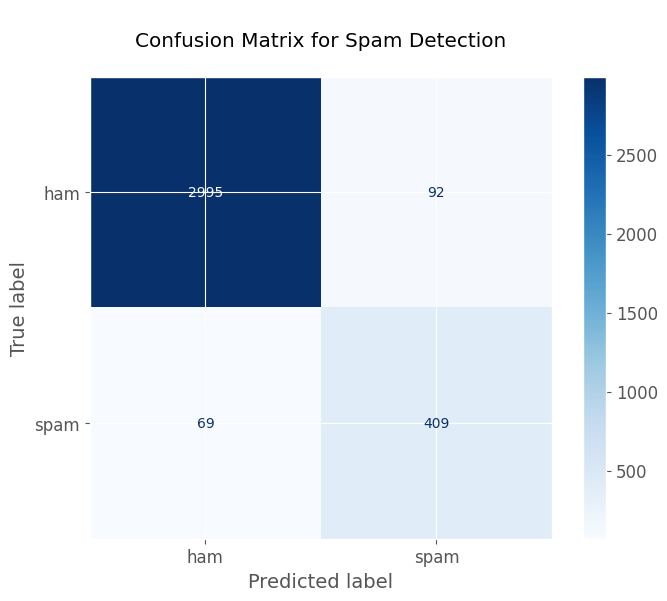

In [15]:
model_eval_metrics(y_tr, y_tr_pred, "Custom Heuristic Model", "Training data")

### 3.1.3 Evaluating the model on validation data

In [16]:
val_with_predictions = classify_messages(val, high_freq_words, token_column_name='Tokens')

In [17]:
val_with_predictions.head()

,Label,Message,Length,Tokens,Spam_Score,Ham_Score,Predicted_Label
0,ham,I want to send something that can sell fast. ...,76,"[want, send, sell, fast, k, easy, money]",2,4,ham
1,ham,"Happy or sad , one thing about past is- ""Its n...",74,"[happy, sad, thing, past, good, morning]",0,4,ham
2,ham,Nvm take ur time.,17,"[nvm, time]",1,1,ham
3,ham,Ill be at yours in about 3 mins but look out f...,51,"[ill, mins, look]",1,0,spam
4,ham,Then u going ikea str aft dat?,30,"[going, ikea, str, aft, dat]",0,1,ham


In [18]:
y_val = val_with_predictions['Label']
y_val_pred = val_with_predictions['Predicted_Label']


### Evaluating Custom Heuristics Model on Validation Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.948
Precision (Spam): 0.785
Recall (Spam): 0.850
F1 Score (Spam): 0.816

Metrics for Ham
--------------------
Accuracy: 0.948
Precision (Ham): 0.976
Recall (Ham): 0.964
F1 Score (Ham): 0.970

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      0.96      0.97       772
        spam       0.78      0.85      0.82       120

    accuracy                           0.95       892
   macro avg       0.88      0.91      0.89       892
weighted avg       0.95      0.95      0.95       892


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 102
True Negatives (TN) (Ham --> Ham): 744
False Positives (FP)(Ham --> Spam): 28
False Negatives (FN) (Spam -->

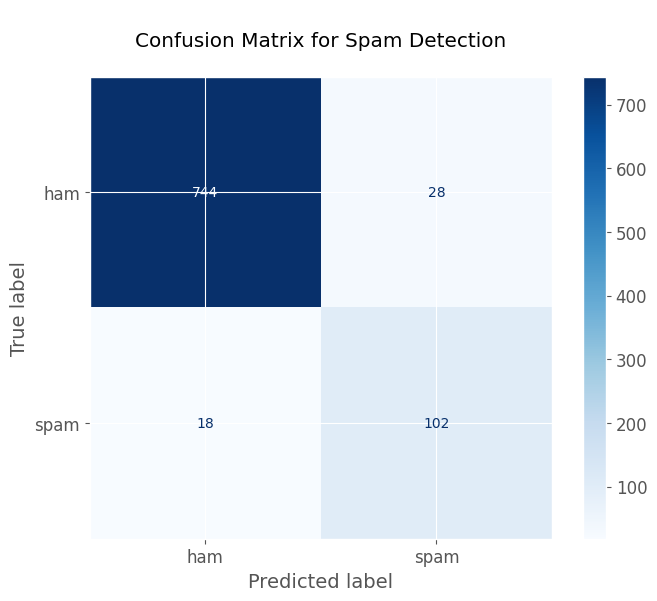

In [19]:
model_eval_metrics(y_val, y_val_pred, "Custom Heuristics Model", "Validation Data")

### 3.2 Rule based model - Decision Tree

In [48]:
train = pd.read_csv('./data/train.csv')
val = pd.read_csv('./data/validation.csv')
test = pd.read_csv('./data/test.csv')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [49]:
train.head()

,Label,Message,Length,Tokens
0,ham,That sucks. So what do you got planned for you...,94,"['sucks', 'got', 'planned', 'yo', 'valentine',..."
1,spam,"FREE RING TONE just text ""POLYS"" to 87131. The...",106,"['free', 'ring', 'tone', 'text', 'polys', 'wee..."
2,ham,Must come later.. I normally bathe him in da a...,60,"['come', 'later', 'normally', 'bathe', 'da', '..."
3,ham,Hi di is yijue we're meeting at 7 pm at esapla...,59,"['hi', 'di', 'yijue', 'meeting', 'pm', 'esapla..."
4,spam,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",163,"['urgent', 'important', 'information', 'user',..."


In [50]:
encoder = LabelEncoder()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.8, stop_words="english")

def features_label_vectorization(df, is_train=True):
    X = df['Tokens']
    y = df['Label']

    if is_train:
        features = vectorizer.fit_transform(X)  
        label = encoder.fit_transform(y)  
        
    else:
        features = vectorizer.transform(X) 
        label = encoder.transform(y) 

    return features, label

In [51]:
X_tr, y_tr = features_label_vectorization(train, is_train=True)

### 3.2.1 Training the Model

In [206]:
dt_clf = DecisionTreeClassifier(class_weight='balanced',
                       max_depth=20, random_state=42)
dt_clf.fit(X_tr, y_tr)

DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=42)

In [207]:
y_tr_pred = dt_clf.predict(X_tr)

In [208]:
def model_eval_metrics(y, y_pred, model_name, data_set_name):
    # Metrics for spam
    print(f"\n### Evaluating {model_name} on {data_set_name} ###")
    print("-" * 75)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=1)
    recall = recall_score(y, y_pred, pos_label=1)
    f1 = f1_score(y, y_pred, pos_label=1)


    print("\nMetrics for Spam")
    print("-" * 20)
    print(f"Accuracy: {accuracy:.3f}") # Overall correctness
    print(f"Precision (Spam): {precision:.3f}") # Out of all messages predicted as spam, how many are actually spam.
    print(f"Recall (Spam): {recall:.3f}") # Out of all actual spam messages, how many were correctly predicted.
    print(f"F1 Score (Spam): {f1:.3f}") # Balance of precision and recall (Harmonic mean)
 
    
    # Metrics for ham
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=0)
    recall = recall_score(y, y_pred, pos_label=0)
    f1 = f1_score(y, y_pred, pos_label=0)

    print("\nMetrics for Ham")
    print("-" * 20)
    print(f"Accuracy: {accuracy:.3f}") # Overall correctness
    print(f"Precision (Ham): {precision:.3f}") # Out of all messages predicted as spam, how many are actually spam.
    print(f"Recall (Ham): {recall:.3f}") # Out of all actual spam messages, how many were correctly predicted.
    print(f"F1 Score (Ham): {f1:.3f}") # Balance of precision and recall (Harmonic mean)

    
    # Full classification report
    print("\nClassification Report")
    print("-" * 50)
    print(classification_report(y, y_pred, target_names=['ham', 'spam']))
    

    # FPR calculation
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\nConfusion Matrix")
    print("-" * 50)
    print(f"True Positives (TP) (Spam --> Spam): {tp}")
    print(f"True Negatives (TN) (Ham --> Ham): {tn}")
    print(f"False Positives (FP)(Ham --> Spam): {fp}")
    print(f"False Negatives (FN) (Spam --> Ham): {fn}")
    
    fpr = fp/(fp+tn) * 100
    print()
    print("*" * 20)
    print(f"FPR is {fpr:.2f}%")
    print("*" * 20)

 
    print("\nClassification Matrix Visualisation")
    print("-" * 50)
    cm_display = ConfusionMatrixDisplay.from_predictions(y_true=y, y_pred=y_pred, display_labels=['ham','spam'], 
                                                        values_format ='d', cmap='Blues')
    plt.title("\nConfusion Matrix for Spam Detection\n")
    plt.show()
    
    return
    

### 3.2.2 Evaluating the model on training data


### Evaluating Decision Tree on Training Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.982
Precision (Spam): 0.966
Recall (Spam): 0.900
F1 Score (Spam): 0.932

Metrics for Ham
--------------------
Accuracy: 0.982
Precision (Ham): 0.985
Recall (Ham): 0.995
F1 Score (Ham): 0.990

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      3087
        spam       0.97      0.90      0.93       478

    accuracy                           0.98      3565
   macro avg       0.98      0.95      0.96      3565
weighted avg       0.98      0.98      0.98      3565


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 430
True Negatives (TN) (Ham --> Ham): 3072
False Positives (FP)(Ham --> Spam): 15
False Negatives (FN) (Spam --> Ham): 48



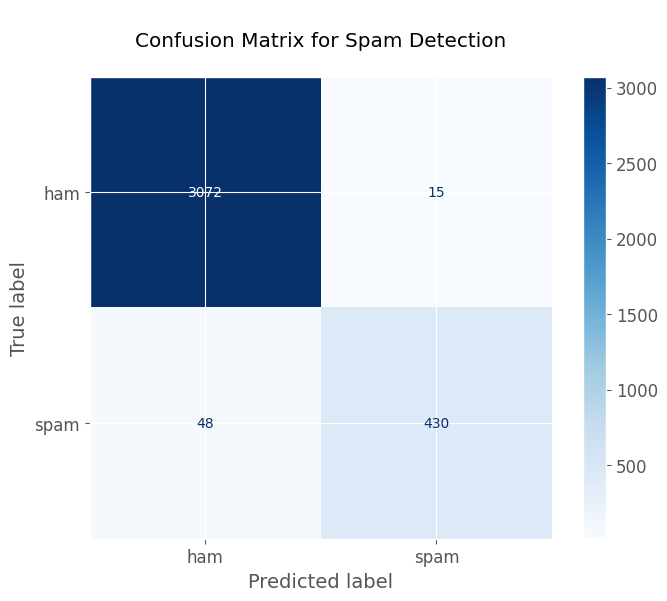

In [209]:
model_eval_metrics(y_tr, y_tr_pred, "Decision Tree", "Training Data")

## <div style="color:blue;font-size:20px">3.2.2 (B) - Using Grid Search to find the best decision tree model</div>

In [210]:
param_grid = {
    'max_depth': [5, 10, 15,20, 25, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 5],  
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'] 
}

dt_clf_grid = DecisionTreeClassifier(class_weight = 'balanced', random_state=42)

precision_scorer = make_scorer(precision_score, average='binary', zero_division=1)

grid_search = GridSearchCV(
    dt_clf_grid, param_grid, scoring=precision_scorer, cv=5, verbose=1, n_jobs=-1
)

grid_search.fit(X_tr, y_tr)


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_precision = grid_search.best_score_


print(f"Best Decision Tree Model: {best_model}")
print(f"Best Hyperparameters: {best_params}")
print(f"Best Precision Score: {best_precision:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Decision Tree Model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, random_state=42, splitter='random')
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best Precision Score: 0.8604


### <div style="color:green;font-size:20px">Grid Search</div>

<div style="color:green;font-size:16px">
    <ul>
        <li>The best parameters are coming out to be somewhat similar to the base model</li>
        <li>We will update the model to reflect this</li>
    </ul>
</div>

In [211]:
dtbest_clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, random_state=42, splitter='random')
dtbest_clf.fit(X_tr, y_tr)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, random_state=42, splitter='random')


### Evaluating Decision Tree on Training Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.988
Precision (Spam): 0.991
Recall (Spam): 0.916
F1 Score (Spam): 0.952

Metrics for Ham
--------------------
Accuracy: 0.988
Precision (Ham): 0.987
Recall (Ham): 0.999
F1 Score (Ham): 0.993

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      3087
        spam       0.99      0.92      0.95       478

    accuracy                           0.99      3565
   macro avg       0.99      0.96      0.97      3565
weighted avg       0.99      0.99      0.99      3565


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 438
True Negatives (TN) (Ham --> Ham): 3083
False Positives (FP)(Ham --> Spam): 4
False Negatives (FN) (Spam --> Ham): 40

*

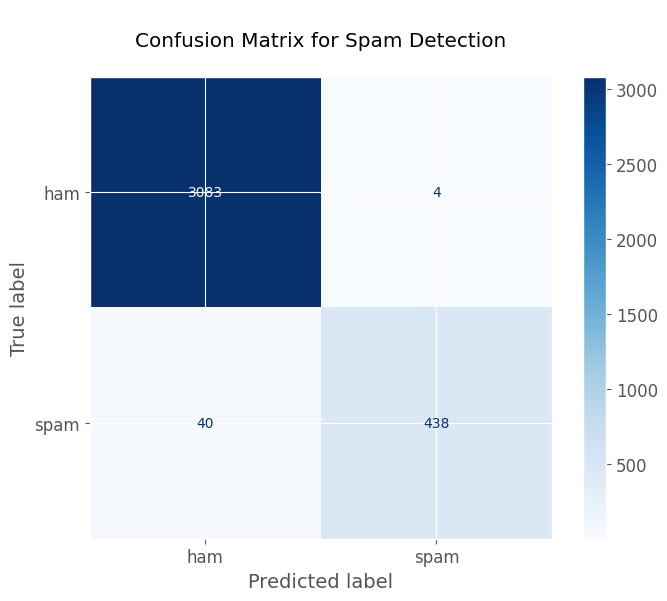

In [212]:
y_tr_pred = dtbest_clf.predict(X_tr)
model_eval_metrics(y_tr, y_tr_pred, "Decision Tree", "Training Data")

### 3.2.3 Evaluating the model on validation data

In [179]:
X_val, y_val = features_label_vectorization(val, is_train=False)
y_val_pred = dtbest_clf.predict(X_val)


### Evaluating Decision Tree on Validation Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.952
Precision (Spam): 0.841
Recall (Spam): 0.792
F1 Score (Spam): 0.815

Metrics for Ham
--------------------
Accuracy: 0.952
Precision (Ham): 0.968
Recall (Ham): 0.977
F1 Score (Ham): 0.972

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.97      0.98      0.97       772
        spam       0.84      0.79      0.82       120

    accuracy                           0.95       892
   macro avg       0.90      0.88      0.89       892
weighted avg       0.95      0.95      0.95       892


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 95
True Negatives (TN) (Ham --> Ham): 754
False Positives (FP)(Ham --> Spam): 18
False Negatives (FN) (Spam --> Ham): 25



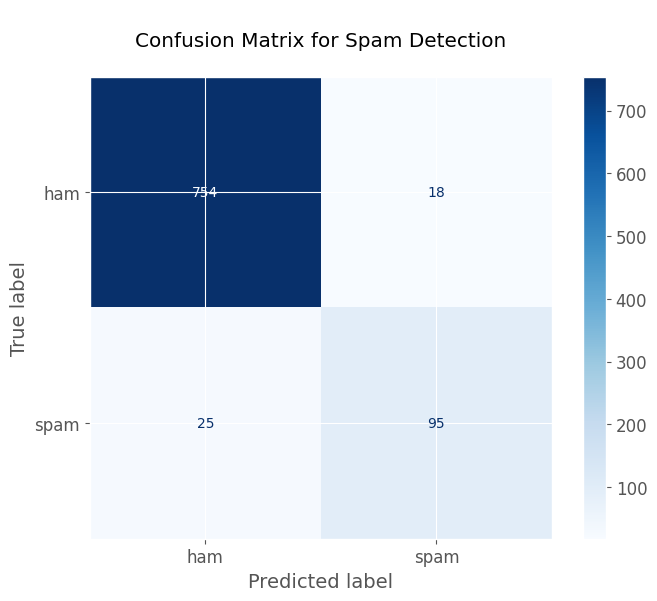

In [180]:
model_eval_metrics(y_val, y_val_pred, "Decision Tree", "Validation Data")

### 3.3 Logistic Regression

### 3.3.1 Training the Model

In [78]:
sgd_clf = SGDClassifier(loss = 'log_loss', penalty = 'l2', alpha = 0.0001, learning_rate = 'constant', 
                          eta0 = 0.01, warm_start = True, max_iter = 1000, random_state = 42)
sgd_clf.fit(X_tr, y_tr)

SGDClassifier(eta0=0.01, learning_rate='constant', loss='log_loss',
              random_state=42, warm_start=True)

### 3.3.2 Evaluating the model on training data

In [79]:
y_tr_pred = sgd_clf.predict(X_tr)


### Evaluating Logistic Regression on Training Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.966
Precision (Spam): 0.986
Recall (Spam): 0.757
F1 Score (Spam): 0.857

Metrics for Ham
--------------------
Accuracy: 0.966
Precision (Ham): 0.964
Recall (Ham): 0.998
F1 Score (Ham): 0.981

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      3087
        spam       0.99      0.76      0.86       478

    accuracy                           0.97      3565
   macro avg       0.98      0.88      0.92      3565
weighted avg       0.97      0.97      0.96      3565


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 362
True Negatives (TN) (Ham --> Ham): 3082
False Positives (FP)(Ham --> Spam): 5
False Negatives (FN) (Spam --> Ham):

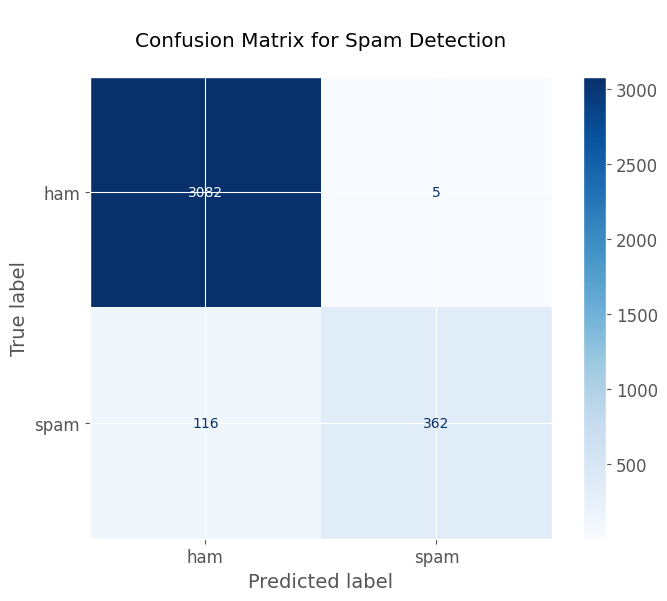

In [80]:
model_eval_metrics(y_tr, y_tr_pred, "Logistic Regression", "Training Data")

### <div style="color:red;font-size:20px">Observations on Mis-classification</div>

<hr>
<div style="color:red;font-size:16px">
    <ul>
        <li>False Negatives (Spam --> Ham) still high, indicated by 0.76 Recall score</li>
        <li>Can we reduce them?</li>
    </ul>
</div>


In [81]:
idx = []
for i in range(len(y_tr)):
    if y_tr[i] == 1 and y_tr_pred[i] == 0:
        idx.append(i)
len(idx)

116

#### Randomly chosing some messages

In [82]:
fn_msgs = train.iloc[idx]
print(fn_msgs.sample(15, random_state=42)['Message'])

2606    Congrats! 1 year special cinema pass for 2 is ...
109     Am new 2 club & dont fink we met yet Will B gr...
1231                08714712388 between 10am-7pm Cost 10p
1212    As a registered optin subscriber ur draw 4 £10...
302     INTERFLORA - It's not too late to order Inter...
1325    Congrats! 1 year special cinema pass for 2 is ...
3427    accordingly. I repeat, just text the word ok o...
1066    SMS. ac Blind Date 4U!: Rodds1 is 21/m from Ab...
2272    Will u meet ur dream partner soon? Is ur caree...
340     Valentines Day Special! Win over £1000 in our ...
1298    FREE2DAY sexy St George's Day pic of Jordan!Tx...
674     Not heard from U4 a while. Call me now am here...
2958    <Forwarded from 21870000>Hi - this is your Mai...
1764    If you don't, your prize will go to another cu...
500     Hi there, 2nights ur lucky night! Uve been inv...
Name: Message, dtype: object


### Plotting the Precision - Recall Curve

In [83]:
y_tr_pred_prob = sgd_clf.predict_proba(X_tr) # predicting probabilities

In [84]:
tr_probs = y_tr_pred_prob[:,1] # taking probabilities for the positive class alone for plotting

In [85]:
precision, recall, thresholds = precision_recall_curve(y_tr, tr_probs)

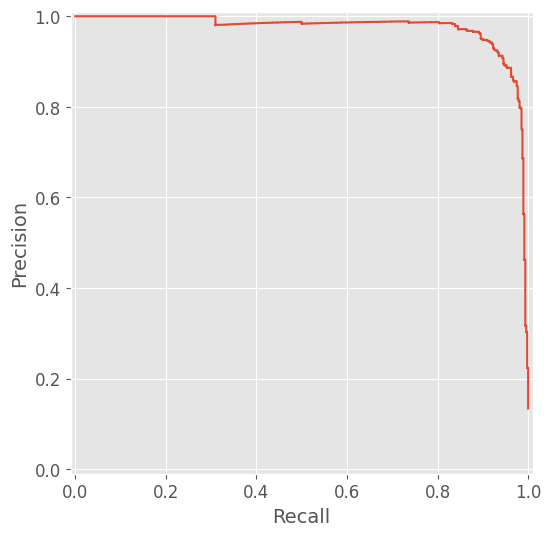

In [86]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();

### Identifying the optimal threshold value

In [87]:
f1_scores = 2 * recall * precision / (recall + precision)
threshold = thresholds[np.argmax(f1_scores)]

print(f'The Optimal threshold value is {threshold:.3f}') 

The Optimal threshold value is 0.282


### <div style="color:green;font-size:20px">Setting classification threshold to $0.282$ to relooking at classification metrics</div>
<hr>


In [88]:
y_tr_th_pred = (sgd_clf.predict_proba(X_tr)[:,1] >= 0.282).astype(int) # new classification with revised threshold


### Evaluating Logistic Regression with new thresholds on Training Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.982
Precision (Spam): 0.942
Recall (Spam): 0.921
F1 Score (Spam): 0.931

Metrics for Ham
--------------------
Accuracy: 0.982
Precision (Ham): 0.988
Recall (Ham): 0.991
F1 Score (Ham): 0.989

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      3087
        spam       0.94      0.92      0.93       478

    accuracy                           0.98      3565
   macro avg       0.96      0.96      0.96      3565
weighted avg       0.98      0.98      0.98      3565


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 440
True Negatives (TN) (Ham --> Ham): 3060
False Positives (FP)(Ham --> Spam): 27
False Negatives

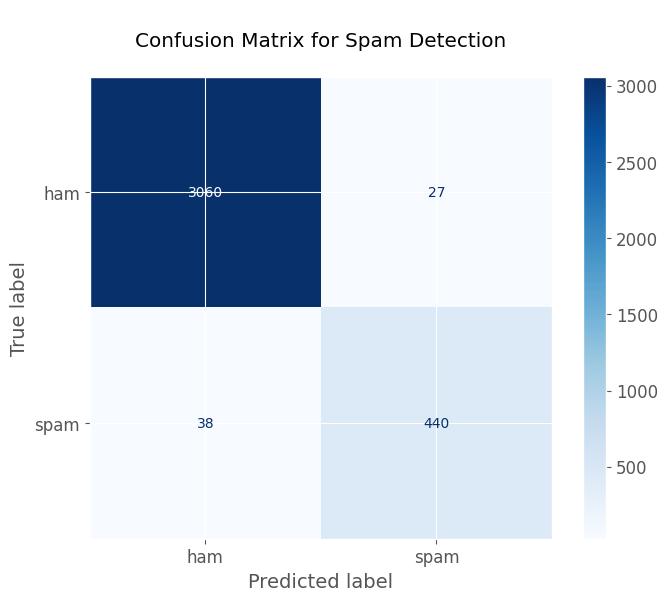

In [89]:
model_eval_metrics(y_tr, y_tr_th_pred, "Logistic Regression with new thresholds", "Training Data")

### <div style="color:green;font-size:20px">Observations with using Adjusted threshold</div>

<hr>
<div style="color:green;font-size:16px;">
    <ul>
        <li>False Negatives (Spam --> Ham) have come down as evidenced by the increase in Recall score to 0.921 from 0.757</li>
        <li>However FPR has gone up marginally to 0.87 from 0.16</li>
    </ul>
</div>


### 3.3.3 Evaluating the model on validation data

In [111]:
y_val_pred = sgd_clf.predict(X_val)


### Evaluating Logistic Regression on Validation Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.955
Precision (Spam): 0.976
Recall (Spam): 0.683
F1 Score (Spam): 0.804

Metrics for Ham
--------------------
Accuracy: 0.955
Precision (Ham): 0.953
Recall (Ham): 0.997
F1 Score (Ham): 0.975

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       772
        spam       0.98      0.68      0.80       120

    accuracy                           0.96       892
   macro avg       0.96      0.84      0.89       892
weighted avg       0.96      0.96      0.95       892


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 82
True Negatives (TN) (Ham --> Ham): 770
False Positives (FP)(Ham --> Spam): 2
False Negatives (FN) (Spam --> Ham):

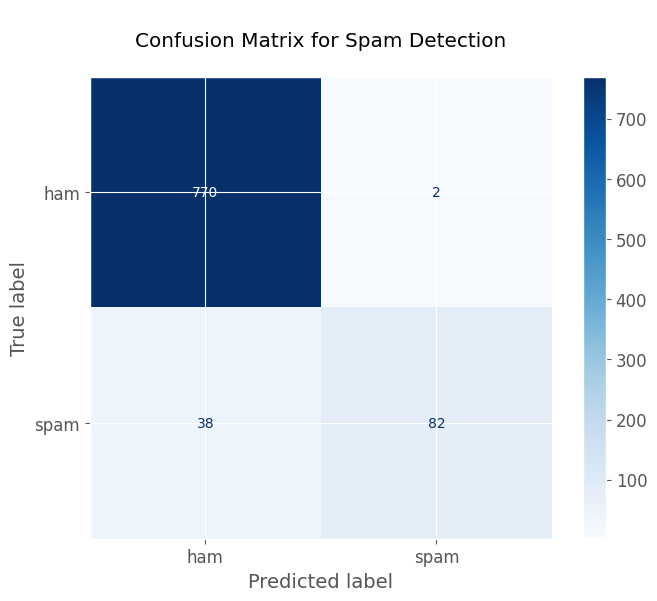

In [112]:
model_eval_metrics(y_val, y_val_pred, "Logistic Regression", "Validation Data")

### 3.4 Support Vector Machine

### 3.4.1 Training the Model

In [125]:
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, random_state=42) 
svm_clf.fit(X_tr, y_tr)

SVC(random_state=42)

### 3.3.2 Evaluating the model on training data

In [126]:
y_tr_pred = svm_clf.predict(X_tr)


### Evaluating Support Vector Machine on Training Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.997
Precision (Spam): 1.000
Recall (Spam): 0.979
F1 Score (Spam): 0.989

Metrics for Ham
--------------------
Accuracy: 0.997
Precision (Ham): 0.997
Recall (Ham): 1.000
F1 Score (Ham): 0.998

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3087
        spam       1.00      0.98      0.99       478

    accuracy                           1.00      3565
   macro avg       1.00      0.99      0.99      3565
weighted avg       1.00      1.00      1.00      3565


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 468
True Negatives (TN) (Ham --> Ham): 3087
False Positives (FP)(Ham --> Spam): 0
False Negatives (FN) (Spam --> Ha

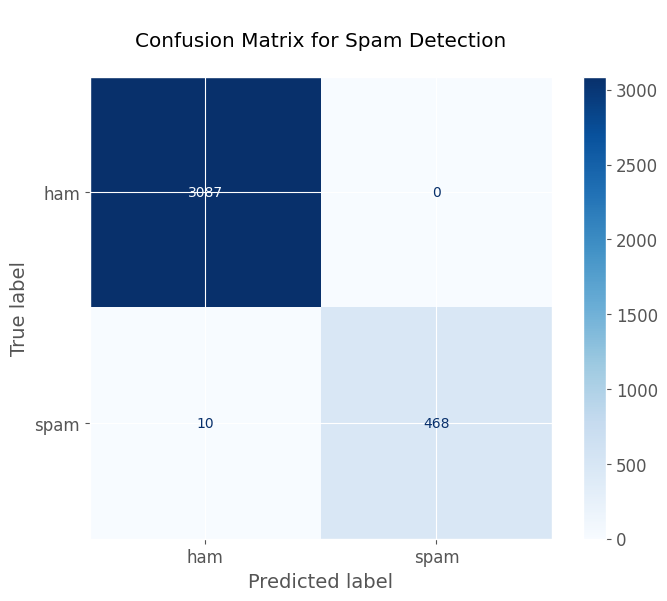

In [127]:
model_eval_metrics(y_tr, y_tr_pred, "Support Vector Machine", "Training Data")

### 3.3.3 Evaluating the model on validation data

In [128]:
y_val_pred = svm_clf.predict(X_val)


### Evaluating Support Vector Machine on Validation Data ###
---------------------------------------------------------------------------

Metrics for Spam
--------------------
Accuracy: 0.974
Precision (Spam): 0.990
Recall (Spam): 0.817
F1 Score (Spam): 0.895

Metrics for Ham
--------------------
Accuracy: 0.974
Precision (Ham): 0.972
Recall (Ham): 0.999
F1 Score (Ham): 0.985

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       772
        spam       0.99      0.82      0.89       120

    accuracy                           0.97       892
   macro avg       0.98      0.91      0.94       892
weighted avg       0.97      0.97      0.97       892


Confusion Matrix
--------------------------------------------------
True Positives (TP) (Spam --> Spam): 98
True Negatives (TN) (Ham --> Ham): 771
False Positives (FP)(Ham --> Spam): 1
False Negatives (FN) (Spam --> Ha

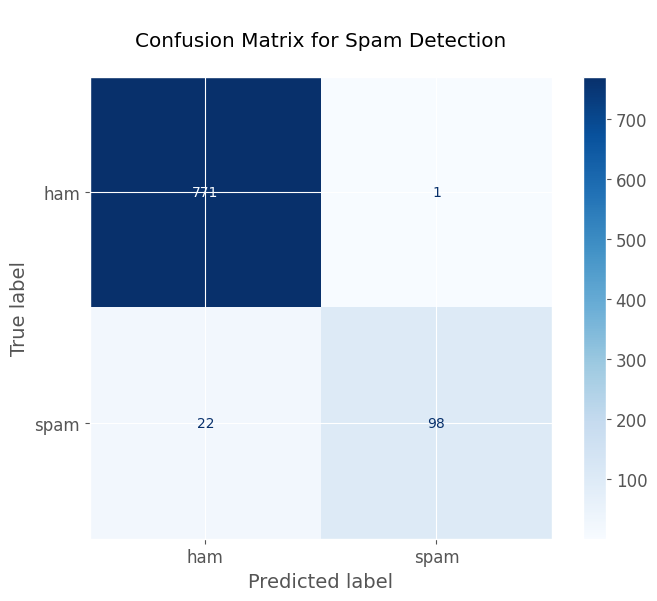

In [129]:
model_eval_metrics(y_val, y_val_pred, "Support Vector Machine", "Validation Data")

## 4. Model Generalization and Stability via Cross Validation

In [130]:
svm_clf_cv = SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, random_state=42) 

In [131]:
cv_scores = cross_val_score(svm_clf_cv, X_tr, y_tr, cv=10, scoring='accuracy', n_jobs=-1)

In [132]:
print("Cross-validation accuracy scores:", np.round(cv_scores,3))
print("Mean accuracy:", np.round(np.mean(cv_scores),3))
print("Standard deviation:", np.round(np.std(cv_scores),3))

Cross-validation accuracy scores: [0.958 0.955 0.98  0.972 0.983 0.958 0.972 0.958 0.98  0.963]
Mean accuracy: 0.968
Standard deviation: 0.01


<hr>
<div style="color:green;font-size:16px"> Accuracy across the 10 folds is quite stable, indicating it is able to generalize well
</div>


## 5. Scoring on Test data and choosing the best Model

In [146]:
X_t, y_t = features_label_vectorization(test, is_train=False)

In [218]:
# Define models dictionary
models = {
    'Decision Tree': dtbest_clf,
    'Logistic Regression (SGD)': sgd_clf,
    'SVM': svm_clf
}

In [219]:
def evaluate_models(models, X, y):
    results = {}

    for name, model in models.items():
        print(f"Evaluating {name}")

        y_pred = model.predict(X)

        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, pos_label=1)
        recall = recall_score(y, y_pred, pos_label=1)
        f1 = f1_score(y, y_pred, pos_label=1)

        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        fpr = fp / (fp + tn) * 100  # False Positive Rate

        results[name] = {
            'Accuracy (Spam)': accuracy,
            'Precision (Spam)': precision,
            'Recall (Spam)': recall,
            'F1 Score (Spam)': f1,
            '% FPR (Ham --> Spam)': np.round(fpr,2)
        }

    # Chosing the best model
    df_results = pd.DataFrame(results).T

    # Select the best model based on Accuracy
    best_model_name = df_results['% FPR (Ham --> Spam)'].idxmin()
    best_model = models[best_model_name]

    return best_model, df_results


In [220]:
# Run evaluation function
best_model, model_results = evaluate_models(models, X_t, y_t)

Evaluating Decision Tree
Evaluating Logistic Regression (SGD)
Evaluating SVM


In [221]:
print("Based on the lowest false positive rate is,")
print(f"\nBest model: {best_model}")

Based on the lowest false positive rate is,

Best model: SGDClassifier(eta0=0.01, learning_rate='constant', loss='log_loss',
              random_state=42, warm_start=True)


In [222]:
model_results

,Accuracy (Spam),Precision (Spam),Recall (Spam),F1 Score (Spam),% FPR (Ham --> Spam)
Decision Tree,0.940807,0.757764,0.818792,0.787097,4.04
Logistic Regression (SGD),0.964126,0.990991,0.738255,0.846154,0.10
SVM,0.971300,0.975610,0.805369,0.882353,0.31
